In [1]:
import sys
sys.path.append("..")

import jax, os, corner
import jax.numpy as jnp
from jax import grad, config
import matplotlib.pyplot as plt
import numpy as np
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)
from functools import partial

# Load reparameterization methods
from src.reparameterization import reparameterization, sigma, logistic_CDF

print(jax.devices())

[cuda(id=0)]


In [ ]:
# Mixture of Gaussian model!

from models.mog_new import MoG 

k = 3
d = 2
weights = jnp.array([2, 4, 5])

mus = jnp.zeros((k, d))
mus = mus.at[0].set(jnp.array([-10, 0]))
mus = mus.at[1].set(jnp.array([0, 0]))
mus = mus.at[2].set(jnp.array([10, 0]))

covs = jnp.zeros((k, d, d))
covs = covs.at[0].set(jnp.eye(d))
covs = covs.at[1].set(jnp.eye(d))
covs = covs.at[2].set(jnp.eye(d))

model = MoG(weights, mus, covs)

model.lower_bound = jnp.array([-15, -15])
model.upper_bound = jnp.array([15, 15])

iid_samples = model.newDrawFromPosterior(1000000)

# Rejection sampling to draw samples from bounded domain
truth_table = ((iid_samples > model.lower_bound) & (iid_samples < model.upper_bound))
idx = np.where(np.all(truth_table, axis=1))[0]
print('%i samples obtained from rejection sampling' % idx.shape[0])
bounded_iid_samples = iid_samples[idx]

corner.corner(bounded_iid_samples)

In [2]:
from models.gw150914 import gwfast_LVGW150914

n_iter = 100000
n_particles = 200
# eps = 1e-6
eps = jnp.ones(9) * 1e-7
eps = eps.at[1].set(1e-5)

model = gwfast_LVGW150914(wf_model='IMRPhenomD', nbins=100, verbose=True)

subset_params = jnp.array([0, 1, 2, 3, 5, 6, 7, 9, 10])
lower = model.lower_bound[subset_params] 
upper = model.upper_bound[subset_params]

# injection wrapper
DoF = len(model.gwfast_param_order)
injection = np.zeros(DoF)
for d in range(DoF):
    injection[d] = model.injParams[model.gwfast_param_order[d]]

X_injection = np.tile(injection, n_particles).reshape(n_particles, DoF)
X_injection_gpu = jnp.array(X_injection)

# Initial draw from reduced prior
X0_all = model._newDrawFromPrior(n_particles)
X0_subset = X0_all[:, subset_params]

# Fix eta coordinate for testing!
# X0_subset = X0_subset.at[:,1].set(jnp.ones(n_particles) * injection[1])

def potential_subset(X_red):
    X_ = X_injection_gpu.at[:, subset_params].set(X_red)
    return model.minusLogLikelihood(X_)

def gradient_subset(X_red):
    X_ = X_injection_gpu.at[:, subset_params].set(X_red)
    return model.gradient_minusLogLikelihood(X_)[:, subset_params]
    


Using waveform model: IMRPhenomD
fmin:  10.0
fmax:  561.1332811724988
df_standard:  5.511332811724987
nbins:  100
Using ASD from file /home/al44828/projects/sSVN_GW/notebooks/aLIGO_O4_high_asd.txt 
Using ASD from file /home/al44828/projects/sSVN_GW/notebooks/aLIGO_O4_high_asd.txt 
Using ASD from file /home/al44828/projects/sSVN_GW/notebooks/AdV_asd.txt 
SNR at true values: 91.44


/tmp/ipykernel_3305449/1647113704.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  injection[d] = model.injParams[model.gwfast_param_order[d]]


buffer in prior: 0.000000


In [17]:
from src.birth_death import birth_death
from src.reparameterization import reparameterized_gradient

# No subset
lower=model.lower_bound 
upper=model.upper_bound

def ula_kernel(key, param, log_post, grad_log_post, dt, iteration, stride=10):
    """ 
    Remarks
    -------
    
    (1) grad_log_post is the gradient of the potential. Change name of this later
    (2) stride = 1 will run birth-death at every iteration!
    
    """
    key, subkey = jax.random.split(key)

    # paramGrad = grad_log_post(param)

    # Transform to unbounded domain (currently includes potential calculation for eventual birth-death step)
    Y, gmlpt_Y = reparameterized_gradient(param, grad_log_post, lower, upper)
    # Y, gmlpt_Y = reparameterized_gradient(param, grad_log_post, model.lower_bound, model.upper_bound)

    # Perform jumps in unbounded domain
    # jumps = jax.lax.cond(jnp.mod(iteration, stride) == 0, lambda: birth_death(key, param, log_post, stepsize=dt, bandwidth=0.001, stride=stride, rate=1, a=model.lower_bound, b=model.upper_bound), lambda: jnp.arange(param.shape[0]))
    # jumps = jax.lax.cond(jnp.mod(iteration, stride) == 0, lambda: birth_death(key, param, log_post, stepsize=dt, bandwidth=0.001, stride=stride, rate=1, a=lower, b=upper), lambda: jnp.arange(param.shape[0]))
    jumps = jax.lax.cond(jnp.mod(iteration, stride) == 0, lambda: birth_death(key, param, log_post, stepsize=jnp.min(dt), bandwidth=0.001, stride=stride, rate=1, a=lower, b=upper), lambda: jnp.arange(param.shape[0]))


    # jumps = birth_death(key, param, log_post, stepsize=dt, bandwidth=0.001, stride=stride, rate=1, a=model.lower_bound, b=model.upper_bound)
    # jumps = jnp.arange(param.shape[0])

    # Perform update in unbounded domain
    Y = Y[jumps] - gmlpt_Y[jumps] * dt + jnp.sqrt(2 * dt) * jax.random.normal(key=subkey, shape=(param.shape))

    # Convert samples back to bounded domain 
    # param = sigma(logistic_CDF(Y), model.lower_bound, model.upper_bound)
    param = sigma(logistic_CDF(Y), lower, upper)

    iteration = iteration + 1

    return key, param, iteration


@partial(jax.jit, static_argnums=(1,2,3))
def ula_sampler_full_jax_jit(key, log_post, grad_log_post, n_iter, dt, x_0):

    # @progress_bar_scan(n_iter)
    def ula_step(carry, x):
        key, param, iteration = carry
        key, param, iteration = ula_kernel(key, param, log_post, grad_log_post, dt, iteration)
        return (key, param, iteration), param

    carry = (key, x_0, 0)
    _, samples = jax.lax.scan(ula_step, carry, None, n_iter)
    return samples

In [18]:
X0 = model._newDrawFromPrior(n_particles)
key = jax.random.PRNGKey(0)

n_iter = 100000
n_particles = 200
eps = 1e-7
# eps = jnp.ones(11) * 5e-7
# eps = eps.at[1].set(5e-5)
# eps = eps.at[4].set(1e-4)
# eps = eps.at[8].set(1e-4)

# For mixture of Gaussian model
# sam = ula_sampler_full_jax_jit(key, jax.vmap(model.potential), jax.vmap(jax.jacfwd(model.potential)), n_iter, eps, X0)

# For subset
# sam = ula_sampler_full_jax_jit(key, potential_subset, gradient_subset, n_iter, eps, X0_subset)

# For whole damn thing
sam = ula_sampler_full_jax_jit(key, model.minusLogLikelihood, model.gradient_minusLogLikelihood, n_iter, eps, X0)

buffer in prior: 0.000000


/home/al44828/miniconda3/envs/myenv5/lib/python3.11/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


In [ ]:
print(model.gwfast_param_order)

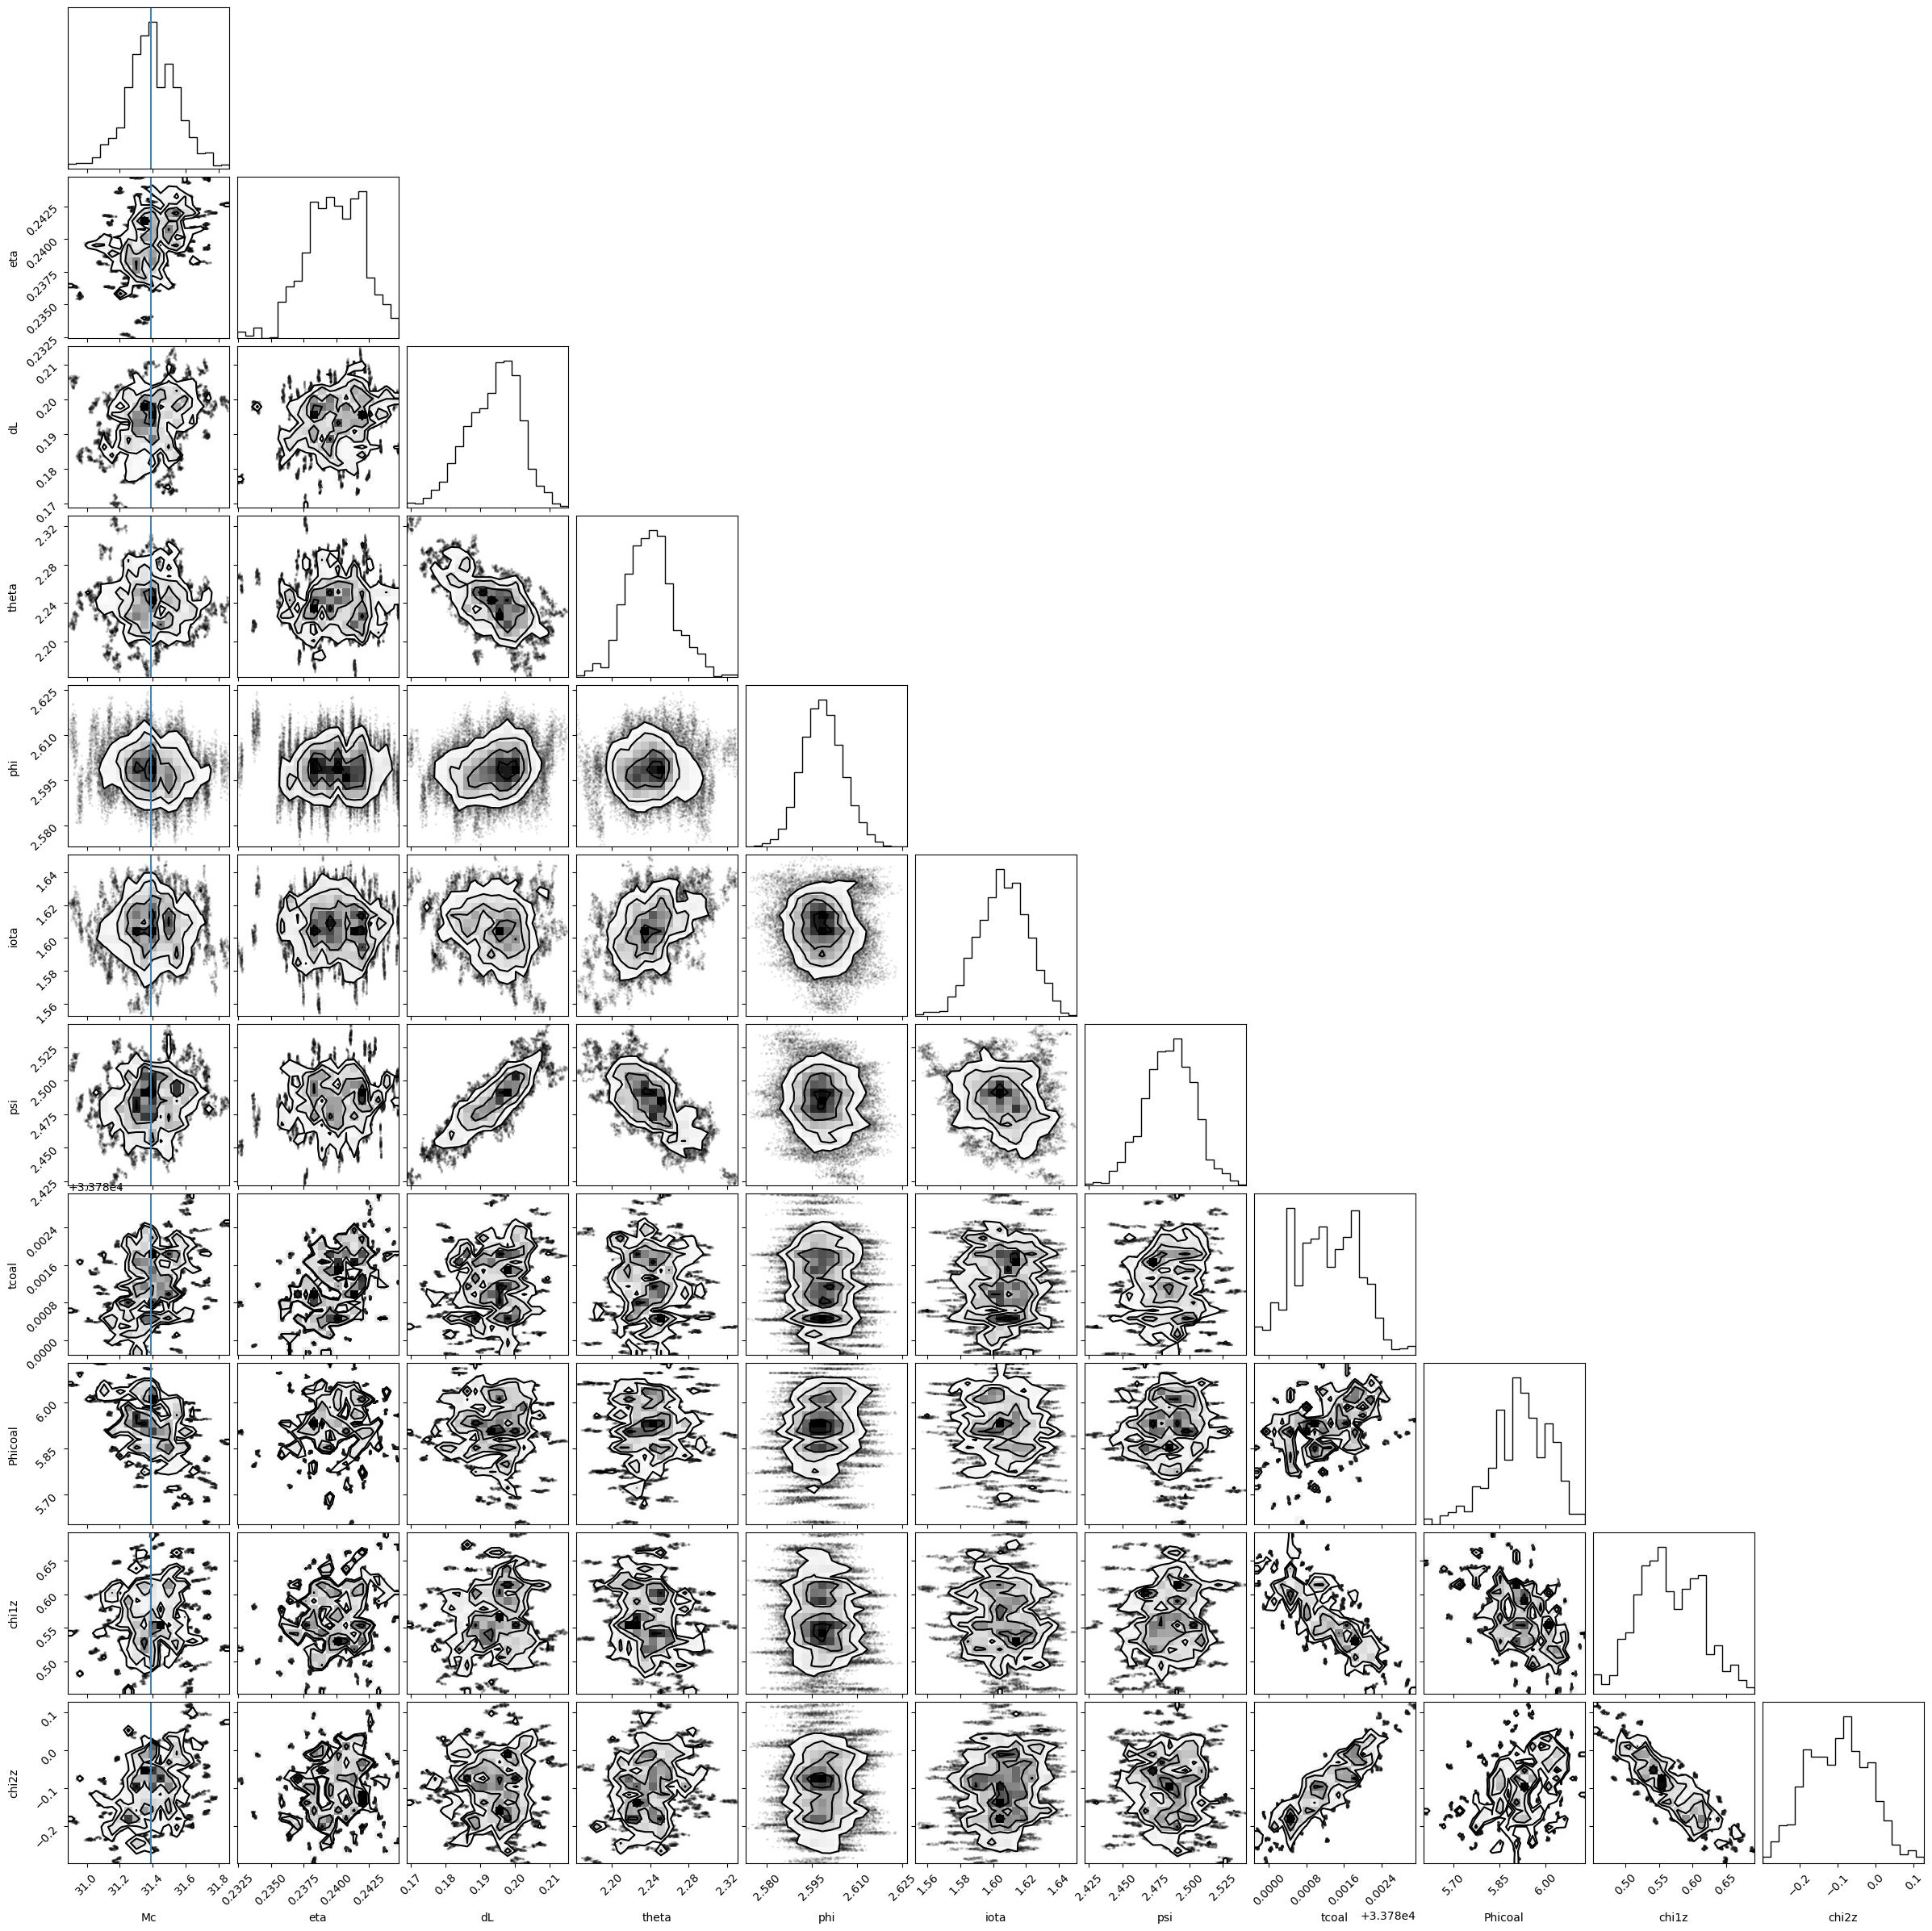

In [19]:
reshaped_matrix = np.array(sam.reshape((n_iter * n_particles, 11)))
fig = corner.corner(reshaped_matrix[-50000:], hist_kwargs={'density':True}, labels=model.gwfast_param_order, truths=model.true_params)

In [ ]:
sam = ula_sampler_full_jax_jit(key, potential_subset, gradient_subset, n_iter, eps, sam[-1])

In [ ]:
reshaped_matrix = np.array(sam.reshape((n_iter * n_particles, len(subset_params))))
labels = np.array(model.gwfast_param_order)[subset_params]
fig = corner.corner(reshaped_matrix[-50000:], hist_kwargs={'density':True}, labels=labels, truths=injection[subset_params])

In [ ]:
import corner
reshaped_matrix = sam.reshape((n_iter * n_particles, model.DoF))
reshaped_matrix = np.array(reshaped_matrix)
fig = corner.corner(reshaped_matrix[-20000:], hist_kwargs={'density':True}, truths=jnp.mean(bounded_iid_samples, axis=0)) # For rosenbrock
# fig = corner.corner(np.array(reshaped_matrix[-60000:]), hist_kwargs={'density':True}, truths=jnp.mean(bounded_iid_samples, axis=0)) # For rosenbrock
corner.corner(bounded_iid_samples[-20000:], color='r', fig=fig, hist_kwargs={'density':True})


# GW PROBLEM